<a href="https://colab.research.google.com/github/bmurphy1993/NYU_bioinformatics_ass1/blob/master/Assignment_01_Biomarkers_Group_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Assignment 1

Group 5: Brian Murphy, Aravind Rajagopalan, Sinthema Roy, Ron Baik

Using the Golub et. al. as a reference:
1.	Recreate Figure 3b - See how many overlaps you have with their top correlated genes
2.	Train a model using the 50 most highly correlated genes (25 AML and 25 ALL) to predict the class of each sample using cross-validation.
3.	Try differing amounts of genes and compare the results eg:(top 2, 10, 100, 1000)
4.	Cluster the data using any method you like (K-Means, Hierarchical). What are the defining features of the clusters?
Optional: Does sample type matter (bone marrow vs peripheral blood)?

Article: https://pubmed.ncbi.nlm.nih.gov/10521349/

Data portal: http://portals.broadinstitute.org/cgi-bin/cancer/publications/pub_paper.cgi?mode=view&paper_id=43


Report Format:

*   Each group will submit a single report (This should be set up on Brightspace now)
*   The report should include:
  *   The tools you used and steps you followed to complete your analysis
  *   Your results and findings
  *   Any changes you made after the progress presentation should be mentioned
  *   A breakdown of how each group member contributed to the project and a score out of 5 per group member
  *   Submit a zipped folder containing your code and a README.md file with instructions to run the code
      *   Or add a link to a GitHub repository containing your code to the report

# Analysis

## Packages

In [1]:
# install packages
!pip install openpyxl

# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats # for calculating z-scores
# import os for working with local files
import os
import seaborn as sns
import math # for the welch's t-test
from tabulate import tabulate # for a pretty table

# generate plots in the jupyter notebook
%matplotlib inline

# set the size of the figures 
sns.set(rc={'figure.figsize':(8,4), 'figure.dpi': 150}) # 12,6 was original figsize
# set the backgrounds of figures to white with a grid
sns.set_style("whitegrid")
# font size
sns.set(font_scale=1)

## 1.	Recreate Figure 3b - See how many overlaps you have with their top correlated genes

Import Data: Train, Test, and metadata

In [2]:
# import train and test data, fix indexing and column names, transpose data
  # train
train = pd.read_csv(
    'http://pubs.broadinstitute.org/mpr/projects/Leukemia/data_set_ALL_AML_train.txt',
    sep='\t',
    index_col=False
    )

# len(train['Gene Accession Number'].unique())
        # no duplicates in Gene Accession Number - 7129 unique vals
train=train.loc[:,~train.columns.str.contains('call')].set_index('Gene Accession Number').drop(columns='Gene Description')

print('train NAs: ',train.isna().sum().sum(),'\n',
      'train: ',train.shape,
      train.head())

  # test
test = pd.read_csv(
    'http://pubs.broadinstitute.org/mpr/projects/Leukemia/data_set_ALL_AML_independent.txt',
    sep='\t',
    index_col=False
    )

# len(test['Gene Accession Number'].unique())
        # no duplicates in Gene Accession Number - 7129 unique vals
test=test.loc[:,~test.columns.str.contains('call')].set_index('Gene Accession Number').drop(columns='Gene Description')

print('test NAs: ',test.isna().sum().sum(),'\n',
      'test: ',test.shape,'\n',
      test.head())

  # Cleaned metadata
meta = pd.read_csv(
    'https://raw.githubusercontent.com/bmurphy1993/NYU_bioinformatics_ass1/master/table_ALL_AML_samples_clean.csv',
    )
# need to do anything with the rescaling factors?

train NAs:  0 
 train:  (7129, 38)                          1    2    3    4    5  ...   29   30   31   32   33
Gene Accession Number                           ...                         
AFFX-BioB-5_at        -214 -139  -76 -135 -106  ...   15 -318  -32 -124 -135
AFFX-BioB-M_at        -153  -73  -49 -114 -125  ... -114 -192  -49  -79 -186
AFFX-BioB-3_at         -58   -1 -307  265  -76  ...    2  -95   49  -37  -70
AFFX-BioC-5_at          88  283  309   12  168  ...  193  312  230  330  337
AFFX-BioC-3_at        -295 -264 -376 -419 -230  ...  -51 -139 -367 -188 -407

[5 rows x 38 columns]
test NAs:  0 
 test:  (7129, 34) 
                         39   40   42   47   48  ...   65   66   63   64   62
Gene Accession Number                           ...                         
AFFX-BioB-5_at        -342  -87   22 -243 -130  ...  -62  -58 -161  -48 -176
AFFX-BioB-M_at        -200 -248 -153 -218 -177  ... -198 -217 -215 -531 -284
AFFX-BioB-3_at          41  262   17 -163  -28  ...   -5   6

Check distribution with charts

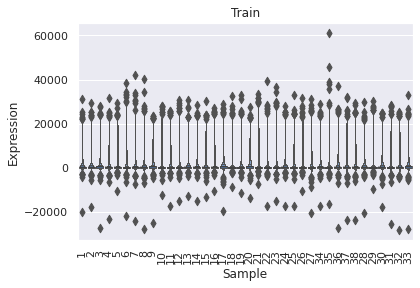

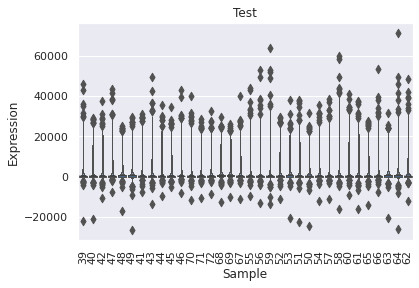

In [3]:
# Train data
sns.boxenplot(data=train, color='#507fbf')
train_box = plt.xticks(rotation=90)
train_box = plt.xlabel('Sample')
train_box = plt.ylabel('Expression')
train_box = plt.title('Train')
plt.show()

# Test data
sns.boxenplot(data=test, color='#507fbf')
test_box = plt.xticks(rotation=90)
test_box = plt.xlabel('Sample')
test_box = plt.ylabel('Expression')
test_box = plt.title('Test')

Transpose data

In [4]:
# Train
train_tr = train.transpose()
train_tr.index=train_tr.index.astype(int)
train_tr.index.name = 'Samples'
train_tr=train_tr.sort_index()
train=train_tr.transpose()

# Test
test_tr = test.transpose()
test_tr.index=test_tr.index.astype(int)
test_tr.index.name = 'Samples'
test_tr=test_tr.sort_index()
test=test_tr.transpose()

Data normalization

In [5]:
# Convert gene expressions into z-scores for each sample across genes
  # Train
cols_train = list(train.columns)
train_z = pd.DataFrame()

for col in cols_train:
  train_z[col] = (train[col] - train[col].mean())/train[col].std(ddof=0)

  # Test
cols_test = list(test.columns)
test_z = pd.DataFrame()

for col in cols_test:
  test_z[col] = (test[col] - test[col].mean())/test[col].std(ddof=0)

print(train_z.head(),'\n\n',test_z.head())

                      1         2         3   ...        36        37        38
AFFX-BioB-5_at -0.377790 -0.335912 -0.311532  ... -0.369196 -0.280829 -0.282606
AFFX-BioB-M_at -0.350848 -0.309177 -0.300669  ... -0.383767 -0.278863 -0.309698
AFFX-BioB-3_at -0.308889 -0.280011 -0.404472  ... -0.238800 -0.222245 -0.253896
AFFX-BioC-5_at -0.244405 -0.164968 -0.156633  ... -0.170800 -0.143215 -0.094980
AFFX-BioC-3_at -0.413565 -0.386547 -0.432233  ... -0.367701 -0.426699 -0.384506

[5 rows x 38 columns] 

                       39        40        41  ...        70        71        72
AFFX-BioB-5_at -0.373591 -0.266775 -0.266661  ... -0.243455 -0.274560 -0.324940
AFFX-BioB-M_at -0.316190 -0.336634 -0.250079  ... -0.238800 -0.298376 -0.322769
AFFX-BioB-3_at -0.218770 -0.115341 -0.243275  ... -0.215098 -0.239052 -0.289765
AFFX-BioC-5_at -0.102754 -0.101022 -0.179922  ... -0.165578 -0.185790 -0.176422
AFFX-BioC-3_at -0.325892 -0.327088 -0.339369  ... -0.265887 -0.323058 -0.357510

[5 rows x 34 

Show z score distributions

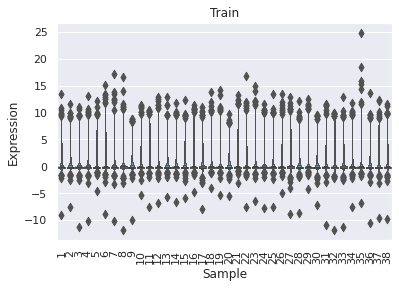

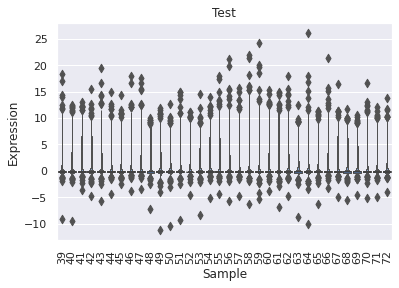

In [6]:
# Train data
sns.boxenplot(data=train_z, color='#507fbf')
train_z_box = plt.xticks(rotation=90)
train_z_box = plt.xlabel('Sample')
train_z_box = plt.ylabel('Expression')
train_z_box = plt.title('Train')
plt.show()

# Test data
sns.boxenplot(data=test_z, color='#507fbf')
test_z_box = plt.xticks(rotation=90)
test_z_box = plt.xlabel('Sample')
test_z_box = plt.ylabel('Expression')
test_z_box = plt.title('Test')

Get ALL and AML Lists

In [7]:
# Split into train and test
meta_train = meta[meta.Set=='Train'].set_index('Samples').drop(columns='Set')
meta_test = meta[meta.Set=='Test'].set_index('Samples').drop(columns='Set')

# Create Sample-Type dictionary
train_dict = dict(zip(meta_train.index, meta_train['ALL/AML']))

# Create ALL and AML lists
ALL_list = list(
    map(lambda x: x[0], 
        filter(
            lambda x: x[1] == 'ALL', 
            train_dict.items()
        )
       )
)

AML_list = list(
    map(lambda x: x[0], 
        filter(
            lambda x: x[1] == 'AML', 
            train_dict.items()
        )
       )
)

print('ALL: ', ALL_list)
print('AML: ', AML_list)

ALL:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
AML:  [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


Rank the genes: sort by Welch's t-test

In [8]:
# Calculate t-test scores to rank genes
train_rank = train_z

  # ALL
train_rank[['ALL_mean', 'ALL_std']] = train_rank[ALL_list].agg(
    ['mean', 'std'], axis=1
)

  # AML
train_rank[['AML_mean', 'AML_std']] = train_rank[AML_list].agg(
    ['mean', 'std'], axis=1
)

# Welch's t-test
def welch_t_test(row):
    return (
        (row['AML_mean'] - row['ALL_mean']) / 
        np.sqrt(
            row['AML_std']**2/len(ALL_list) + row['ALL_std']**2/len(AML_list)
        )
    )

train_rank['similarity'] = train_rank[['AML_mean', 'AML_std', 'ALL_mean', 'ALL_std']].apply(welch_t_test, axis=1)

# Rank the genes by similarity
train_sorted = train_rank.sort_values('similarity').drop(columns=['ALL_mean', 'ALL_std', 'AML_mean', 'AML_std', 'similarity'])

Test Welch's 

Get top 25 ALL and AML

In [9]:
# Ranks
train_groups = train_sorted.head(25).append(train_sorted.tail(25))

# normalize again:
train_groups_tr=train_groups.transpose()
cols_train = list(train_groups_tr.columns)
train_norm = pd.DataFrame()

for col in cols_train:
  train_norm[col] = (train_groups_tr[col] - train_groups_tr[col].mean())/train_groups_tr[col].std(ddof=0)

train_norm=train_norm.transpose()

# Test
# Subset to top 50 from train data
test_groups = test_z[train_z.index.isin(train_groups.index)]

# normalize again:
test_groups_tr=test_groups.transpose()
cols_test = list(test_groups_tr.columns)
test_norm = pd.DataFrame()

for col in cols_test:
  test_norm[col] = (test_groups_tr[col] - test_groups_tr[col].mean())/test_groups_tr[col].std(ddof=0)

test_norm=test_norm.transpose()

Compare to Golub list of genes

Golub_matches =  33


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


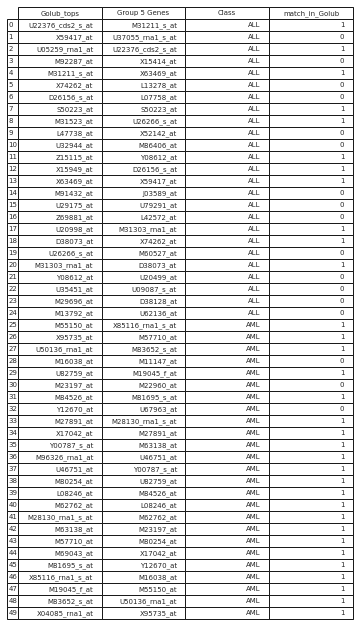

In [10]:
Golub_tops = pd.read_csv(
    'https://raw.githubusercontent.com/bmurphy1993/NYU_bioinformatics_ass1/master/Golub_genes.csv'
)

golub_compare = Golub_tops
golub_compare['Group 5 Genes'] = train_norm.index
golub_compare = golub_compare[['Golub_tops', 'Group 5 Genes', 'Class']]

match_golub = []
for i in golub_compare['Group 5 Genes']:
  gene = [i]
  if any(elem in gene for elem in golub_compare['Golub_tops'].tolist()) == True:
    match = 1
  else:
    match = 0
  match_golub.append(match)
golub_compare['match_in_Golub'] = match_golub

print('Golub_matches = ', golub_compare['match_in_Golub'].sum())
# print(tabulate(golub_compare, headers='keys', tablefmt='psql'))


from pandas.plotting import table 

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, golub_compare, rowLabels=['']*golub_compare.shape[0], loc='center')

Create heatmap

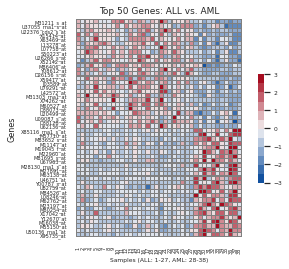

In [11]:
sns.set(font_scale=.3)

cmap = sns.diverging_palette(255, 10, s=95, l=35, n=12)

train_heat = sns.heatmap(data=train_norm,
                         cmap=cmap, 
                         square=1,
                         vmin=-3, vmax=3,
                         cbar_kws={"shrink": .5},
                         linewidth=0.1,
                         linecolor='gray')
plt.title('Top 50 Genes: ALL vs. AML', size=9)
plt.ylabel('Genes', size=8)
plt.xlabel('Samples (ALL: 1-27, AML: 28-38)', size=6)
plt.xticks(size=5, rotation='vertical')
plt.yticks(size=5)
cbar = train_heat.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)

## Prediction Model

### More Packages

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import LeaveOneOut

### 2.	Train a model using the 50 most highly correlated genes (25 AML and 25 ALL) to predict the class of each sample using cross-validation.


Merge Metadata

In [13]:
# Merge cleaned metadata with each dataset
  # Split into train and test
meta_train = meta[meta.Set=='Train'].set_index('Samples').drop(columns='Set')
meta_test = meta[meta.Set=='Test'].set_index('Samples').drop(columns='Set')

  # Merge with train and test datasets
train_norm_tr = train_norm.transpose()
train_merge = train_norm_tr.merge(meta_train, left_index=True, right_index=True)

# Only keep 'ALL/AML' for now
train_labeled = train_merge.drop(columns=['BM/PB', 'T/B-cell', 'FAB', 'Date/Gender', '% Blasts', 'Treatment Response', 'PS', 'Source']).rename(columns={"ALL/AML": "label"})
train_labeled['label'] = train_labeled['label'].astype('category')
train_labeled['label_codes'] = train_labeled['label'].cat.codes

# Test
test_norm_tr = test_norm.transpose()
test_merge = test_norm_tr.merge(meta_test, left_index=True, right_index=True)

# Only keep 'ALL/AML' for now
test_labeled = test_merge.drop(columns=['BM/PB', 'T/B-cell', 'FAB', 'Date/Gender', '% Blasts', 'Treatment Response', 'PS', 'Source']).rename(columns={"ALL/AML": "label"})
test_labeled['label'] = test_labeled['label'].astype('category')
test_labeled['label_codes'] = test_labeled['label'].cat.codes

Split train dataset into it's own train and test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    train_labeled.drop(columns=['label', 'label_codes']), 
    train_labeled['label_codes'], 
    test_size=.73,
    random_state=42)

Train logistic regression and predict the test portion

In [15]:
lr = LogisticRegression(random_state=0, solver='lbfgs')
# train the model using the training data
clf = lr.fit(X_train, y_train)
# now that the model has been trained, predict the classes in the test set
pred = clf.predict(X_test)
# predict outputs labels, decision_function outputs the confidence scores
y_scores = clf.decision_function(X_test)
# print the accuracy sum(predicted == actual) / len(labels)
print('Predicted Class:\t', pred)
print('Actual Class: \t\t', y_test.to_numpy())

Predicted Class:	 [1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0]
Actual Class: 		 [1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0]


Show y-scores

In [16]:
# y_scores contains the confidence scores
    # BM: what is the significance of these numbers? How do we interpret
y_scores

array([ 4.95980794,  6.33451743, -4.2545813 , -2.64687349,  3.85095921,
       -3.99161096, -3.09977611,  2.80609294, -1.82241252, -5.48720951,
       -2.13434466, -5.12055977, -3.54250333, -5.82891396, -7.03236619,
       -3.05288414,  5.66154446, -4.44731914, -4.11775511, -3.7458361 ,
       -0.40646246, -0.58764889,  3.65236418, -2.24136937, -4.52229908,
        7.83969402,  7.74694684, -3.66515957])

Calculate accuracy

In [17]:
# scoring the model will return the accuracy
# this uses the test features and test labels
clf.score(X_test, y_test)

1.0

Create confusion matrix

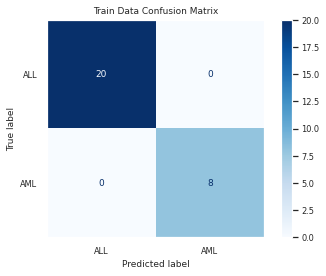

In [18]:
sns.set(font_scale=.75)

disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=train_labeled['label'].cat.categories,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Train Data Confusion Matrix')
disp.ax_.grid(False)
disp.ax_.tick_params(axis='x')

_ = disp.confusion_matrix

Try the trained model on the Golub test dataset

In [19]:
test_predict = test_labeled.drop(columns=['label', 'label_codes'])[train_labeled.drop(columns=['label', 'label_codes']).columns]
test_actual = test_labeled['label_codes']

# train the model using the training data
clf = lr.fit(train_labeled.drop(columns=['label', 'label_codes']), train_labeled['label_codes'])
# now that the model has been trained, predict the classes in the test set
pred_test = clf.predict(test_predict)

print('Predicted Class:\t', pred_test)
print('Actual Class: \t\t', test_actual.to_numpy())
print('Accuracy: \t\t',clf.score(test_predict, test_actual))

Predicted Class:	 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0]
Actual Class: 		 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
Accuracy: 		 0.8529411764705882


Test Data Confusion Matrix

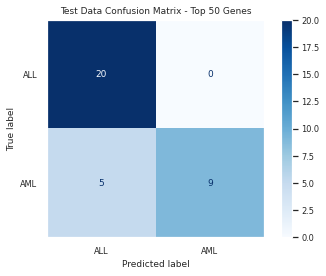

In [20]:
disp_test = plot_confusion_matrix(clf, test_predict, test_actual,
                                 display_labels=test_labeled['label'].cat.categories,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp_test.ax_.set_title('Test Data Confusion Matrix - Top 50 Genes')
disp_test.ax_.grid(False)
disp_test.ax_.tick_params(axis='x')

_test = disp_test.confusion_matrix

Cross-validation

In [21]:
# Leave one out cross validation using scikit

# Create a new LeaveOneOut object and assign it to loo
loo = LeaveOneOut()
# Calculate the number of splits, this uses the number of rows in the features set
loo.get_n_splits(train_labeled)

max_probs = []

# loo.split(features) will return column indexes for train and test sets
# . the train will have len(samples) -1 elements
# . the test set will contain a single index
for train_index, test_index in loo.split(train_labeled):
    # split the data into train and test sets using the indicies
    train_labeled, 
    train_labeled
    X_train = train_labeled.iloc[train_index].drop(columns=['label', 'label_codes'])
    X_test = train_labeled.iloc[test_index].drop(columns=['label', 'label_codes'])
    y_train = train_labeled.iloc[train_index]['label_codes']
    y_test = train_labeled.iloc[test_index]['label_codes']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='lbfgs')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    # print the accuracy of the model using the test set
    print(clf.score(X_test, y_test), end=', ')
    # this will output the probilites per test case
    #   as we only have one test we can use zero to index it
    max_probs.append(max(clf.predict_proba(X_test)[0]))

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 

Plot prediction strength

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Prediction Strength - Top 50 genes')

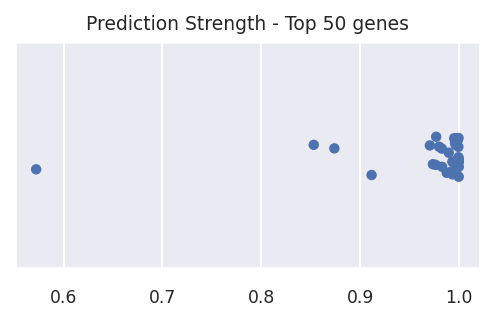

In [22]:
fig = plt.figure(figsize=(4, 2), dpi=150)
g = sns.stripplot(max_probs)
plt.title('Prediction Strength - Top 50 genes')

## 3.	Try differing amounts of genes and compare the results eg:(top 2, 10, 100, 1000)


Index(['M31211_s_at', 'U37055_rna1_s_at', 'U50136_rna1_at', 'X95735_at'], dtype='object')
Predicted Class:	 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0]
Actual Class: 		 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
Accuracy: 		 0.8235294117647058 

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Prediction Strength - Top 2 Genes')

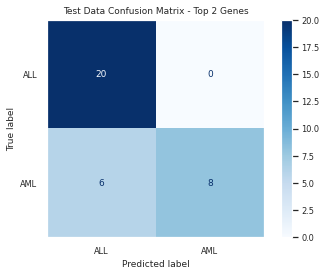

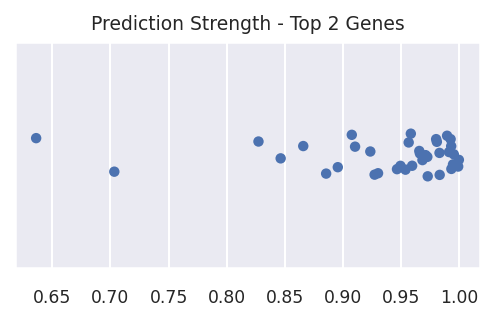

In [23]:
# top 2 genes
# Ranks
train_groups2 = train_sorted.head(2).append(train_sorted.tail(2))
print(train_groups2.index)

# normalize again:
train_groups2_tr=train_groups2.transpose()
cols_train2 = list(train_groups2_tr.columns)
train_norm2 = pd.DataFrame()

for col in cols_train2:
  train_norm2[col] = (train_groups2_tr[col] - train_groups2_tr[col].mean())/train_groups2_tr[col].std(ddof=0)

train_norm2=train_norm2.transpose()

# Test
# Subset to top 2 from train data
test_groups2 = test_z[train_z.index.isin(train_groups2.index)]

# normalize again:
test_groups2_tr=test_groups2.transpose()
cols_test2 = list(test_groups2_tr.columns)
test_norm2 = pd.DataFrame()

for col in cols_test2:
  test_norm2[col] = (test_groups2_tr[col] - test_groups2_tr[col].mean())/test_groups2_tr[col].std(ddof=0)

test_norm2=test_norm2.transpose()

  # Merge with train and test datasets
train_norm2_tr = train_norm2.transpose()
train_merge2 = train_norm2_tr.merge(meta_train, left_index=True, right_index=True)

# Only keep 'ALL/AML' for now
train_labeled2 = train_merge2.drop(
    columns=['BM/PB', 'T/B-cell', 'FAB', 'Date/Gender', '% Blasts', 'Treatment Response', 'PS', 'Source']).rename(
        columns={"ALL/AML": "label"})
train_labeled2['label'] = train_labeled2['label'].astype('category')
train_labeled2['label_codes'] = train_labeled2['label'].cat.codes

# Test
test_norm2_tr = test_norm2.transpose()
test_merge2 = test_norm2_tr.merge(meta_test, left_index=True, right_index=True)

# Only keep 'ALL/AML' for now
test_labeled2 = test_merge2.drop(
    columns=['BM/PB', 'T/B-cell', 'FAB', 'Date/Gender', '% Blasts', 'Treatment Response', 'PS', 'Source']).rename(
        columns={"ALL/AML": "label"})
test_labeled2['label'] = test_labeled2['label'].astype('category')
test_labeled2['label_codes'] = test_labeled2['label'].cat.codes

# Train and test model with top 2 genes
test_predict2 = test_labeled2.drop(columns=['label', 'label_codes'])[train_labeled2.drop(columns=['label', 'label_codes']).columns]
test_actual2 = test_labeled2['label_codes']

# train the model using the training data
clf = lr.fit(train_labeled2.drop(columns=['label', 'label_codes']), train_labeled2['label_codes'])
# now that the model has been trained, predict the classes in the test set
pred_test2 = clf.predict(test_predict2)

print('Predicted Class:\t', pred_test2)
print('Actual Class: \t\t', test_actual2.to_numpy())
print('Accuracy: \t\t',clf.score(test_predict2, test_actual2),'\n')

# Confusion Matrix
disp_test2 = plot_confusion_matrix(clf, test_predict2, test_actual2,
                                 display_labels=test_labeled2['label'].cat.categories,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp_test2.ax_.set_title('Test Data Confusion Matrix - Top 2 Genes')
disp_test2.ax_.grid(False)
disp_test2.ax_.tick_params(axis='x')

_test2 = disp_test2.confusion_matrix

# Cross Validation

# Create a new LeaveOneOut object and assign it to loo
loo = LeaveOneOut()
# Calculate the number of splits, this uses the number of rows in the features set
loo.get_n_splits(train_labeled2)

max_probs = []

# loo.split(features) will return column indexes for train and test sets
# . the train will have len(samples) -1 elements
# . the test set will contain a single index
for train_index, test_index in loo.split(train_labeled2):
    # split the data into train and test sets using the indicies
    train_labeled2, 
    train_labeled2
    X_train = train_labeled2.iloc[train_index].drop(columns=['label', 'label_codes'])
    X_test = train_labeled2.iloc[test_index].drop(columns=['label', 'label_codes'])
    y_train = train_labeled2.iloc[train_index]['label_codes']
    y_test = train_labeled2.iloc[test_index]['label_codes']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='lbfgs')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    # print the accuracy of the model using the test set
    print(clf.score(X_test, y_test), end=', ')
    # this will output the probilites per test case
    #   as we only have one test we can use zero to index it
    max_probs.append(max(clf.predict_proba(X_test)[0]))

fig = plt.figure(figsize=(4, 2), dpi=150)
g = sns.stripplot(max_probs)
plt.title('Prediction Strength - Top 2 Genes')

Index(['M31211_s_at', 'U37055_rna1_s_at', 'U22376_cds2_s_at', 'X15414_at',
       'X63469_at', 'L13278_at', 'L07758_at', 'S50223_at', 'U26266_s_at',
       'X52142_at',
       ...
       'L08246_at', 'M62762_at', 'M23197_at', 'M80254_at', 'X17042_at',
       'Y12670_at', 'M16038_at', 'M55150_at', 'U50136_rna1_at', 'X95735_at'],
      dtype='object', length=200)
Predicted Class:	 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0]
Actual Class: 		 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
Accuracy: 		 0.8823529411764706 

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Prediction Strength - Top 100 Genes')

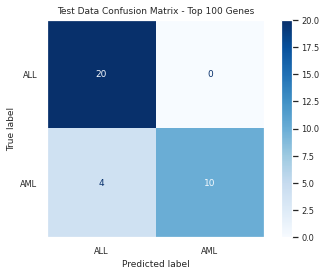

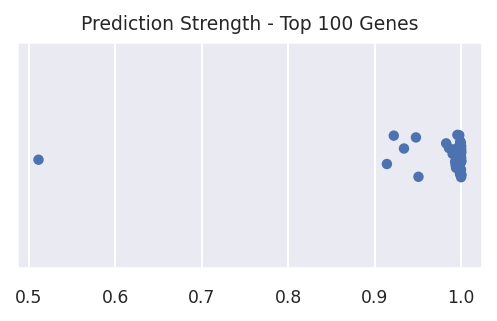

In [24]:
# top 100 genes
# Ranks
train_groups100 = train_sorted.head(100).append(train_sorted.tail(100))
print(train_groups100.index)

# normalize again:
train_groups100_tr=train_groups100.transpose()
cols_train100 = list(train_groups100_tr.columns)
train_norm100 = pd.DataFrame()

for col in cols_train100:
  train_norm100[col] = (train_groups100_tr[col] - train_groups100_tr[col].mean())/train_groups100_tr[col].std(ddof=0)

train_norm100=train_norm100.transpose()

# Test
# Subset to top 100 from train data
test_groups100 = test_z[train_z.index.isin(train_groups100.index)]

# normalize again:
test_groups100_tr=test_groups100.transpose()
cols_test100 = list(test_groups100_tr.columns)
test_norm100 = pd.DataFrame()

for col in cols_test100:
  test_norm100[col] = (test_groups100_tr[col] - test_groups100_tr[col].mean())/test_groups100_tr[col].std(ddof=0)

test_norm100=test_norm100.transpose()

  # Merge with train and test datasets
train_norm100_tr = train_norm100.transpose()
train_merge100 = train_norm100_tr.merge(meta_train, left_index=True, right_index=True)

# Only keep 'ALL/AML' for now
train_labeled100 = train_merge100.drop(
    columns=['BM/PB', 'T/B-cell', 'FAB', 'Date/Gender', '% Blasts', 'Treatment Response', 'PS', 'Source']).rename(
        columns={"ALL/AML": "label"})
train_labeled100['label'] = train_labeled100['label'].astype('category')
train_labeled100['label_codes'] = train_labeled100['label'].cat.codes

# Test
test_norm100_tr = test_norm100.transpose()
test_merge100 = test_norm100_tr.merge(meta_test, left_index=True, right_index=True)

# Only keep 'ALL/AML' for now
test_labeled100 = test_merge100.drop(
    columns=['BM/PB', 'T/B-cell', 'FAB', 'Date/Gender', '% Blasts', 'Treatment Response', 'PS', 'Source']).rename(
        columns={"ALL/AML": "label"})
test_labeled100['label'] = test_labeled100['label'].astype('category')
test_labeled100['label_codes'] = test_labeled100['label'].cat.codes

# Train and test model with top 100 genes
test_predict100 = test_labeled100.drop(columns=['label', 'label_codes'])[train_labeled100.drop(columns=['label', 'label_codes']).columns]
test_actual100 = test_labeled100['label_codes']

# train the model using the training data
clf = lr.fit(train_labeled100.drop(columns=['label', 'label_codes']), train_labeled100['label_codes'])
# now that the model has been trained, predict the classes in the test set
pred_test100 = clf.predict(test_predict100)

print('Predicted Class:\t', pred_test100)
print('Actual Class: \t\t', test_actual100.to_numpy())
print('Accuracy: \t\t',clf.score(test_predict100, test_actual100),'\n')

# Confusion Matrix
disp_test100 = plot_confusion_matrix(clf, test_predict100, test_actual100,
                                 display_labels=test_labeled100['label'].cat.categories,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp_test100.ax_.set_title('Test Data Confusion Matrix - Top 100 Genes')
disp_test100.ax_.grid(False)
disp_test100.ax_.tick_params(axis='x')

_test100 = disp_test100.confusion_matrix

# Cross Validation

# Create a new LeaveOneOut object and assign it to loo
loo = LeaveOneOut()
# Calculate the number of splits, this uses the number of rows in the features set
loo.get_n_splits(train_labeled100)

max_probs = []

# loo.split(features) will return column indexes for train and test sets
# . the train will have len(samples) -1 elements
# . the test set will contain a single index
for train_index, test_index in loo.split(train_labeled100):
    # split the data into train and test sets using the indicies
    train_labeled100, 
    train_labeled100
    X_train = train_labeled100.iloc[train_index].drop(columns=['label', 'label_codes'])
    X_test = train_labeled100.iloc[test_index].drop(columns=['label', 'label_codes'])
    y_train = train_labeled100.iloc[train_index]['label_codes']
    y_test = train_labeled100.iloc[test_index]['label_codes']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='lbfgs')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    # print the accuracy of the model using the test set
    print(clf.score(X_test, y_test), end=', ')
    # this will output the probilites per test case
    #   as we only have one test we can use zero to index it
    max_probs.append(max(clf.predict_proba(X_test)[0]))

fig = plt.figure(figsize=(4, 2), dpi=150)
g = sns.stripplot(max_probs)
plt.title('Prediction Strength - Top 100 Genes')

Index(['M31211_s_at', 'U37055_rna1_s_at', 'U22376_cds2_s_at', 'X15414_at',
       'X63469_at', 'L13278_at', 'L07758_at', 'S50223_at', 'U26266_s_at',
       'X52142_at',
       ...
       'L08246_at', 'M62762_at', 'M23197_at', 'M80254_at', 'X17042_at',
       'Y12670_at', 'M16038_at', 'M55150_at', 'U50136_rna1_at', 'X95735_at'],
      dtype='object', length=2000)
Predicted Class:	 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0]
Actual Class: 		 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
Accuracy: 		 0.8235294117647058 

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Prediction Strength - Top 1000 Genes')

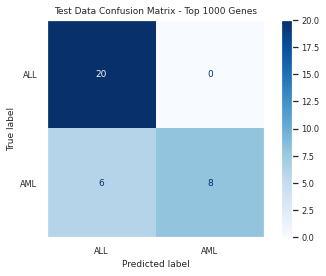

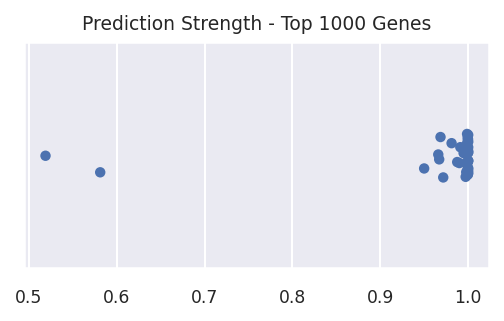

In [25]:
# top 1000 genes
# Ranks
train_groups1000 = train_sorted.head(1000).append(train_sorted.tail(1000))
print(train_groups1000.index)

# normalize again:
train_groups1000_tr=train_groups1000.transpose()
cols_train1000 = list(train_groups1000_tr.columns)
train_norm1000 = pd.DataFrame()

for col in cols_train1000:
  train_norm1000[col] = (train_groups1000_tr[col] - train_groups1000_tr[col].mean())/train_groups1000_tr[col].std(ddof=0)

train_norm1000=train_norm1000.transpose()

# Test
# Subset to top 1000 from train data
test_groups1000 = test_z[train_z.index.isin(train_groups1000.index)]

# normalize again:
test_groups1000_tr=test_groups1000.transpose()
cols_test1000 = list(test_groups1000_tr.columns)
test_norm1000 = pd.DataFrame()

for col in cols_test1000:
  test_norm1000[col] = (test_groups1000_tr[col] - test_groups1000_tr[col].mean())/test_groups1000_tr[col].std(ddof=0)

test_norm1000=test_norm1000.transpose()

  # Merge with train and test datasets
train_norm1000_tr = train_norm1000.transpose()
train_merge1000 = train_norm1000_tr.merge(meta_train, left_index=True, right_index=True)

# Only keep 'ALL/AML' for now
train_labeled1000 = train_merge1000.drop(
    columns=['BM/PB', 'T/B-cell', 'FAB', 'Date/Gender', '% Blasts', 'Treatment Response', 'PS', 'Source']).rename(
        columns={"ALL/AML": "label"})
train_labeled1000['label'] = train_labeled1000['label'].astype('category')
train_labeled1000['label_codes'] = train_labeled1000['label'].cat.codes

# Test
test_norm1000_tr = test_norm1000.transpose()
test_merge1000 = test_norm1000_tr.merge(meta_test, left_index=True, right_index=True)

# Only keep 'ALL/AML' for now
test_labeled1000 = test_merge1000.drop(
    columns=['BM/PB', 'T/B-cell', 'FAB', 'Date/Gender', '% Blasts', 'Treatment Response', 'PS', 'Source']).rename(
        columns={"ALL/AML": "label"})
test_labeled1000['label'] = test_labeled1000['label'].astype('category')
test_labeled1000['label_codes'] = test_labeled1000['label'].cat.codes

# Train and test model with top 1000 genes
test_predict1000 = test_labeled1000.drop(columns=['label', 'label_codes'])[train_labeled1000.drop(columns=['label', 'label_codes']).columns]
test_actual1000 = test_labeled1000['label_codes']

# train the model using the training data
clf = lr.fit(train_labeled1000.drop(columns=['label', 'label_codes']), train_labeled1000['label_codes'])
# now that the model has been trained, predict the classes in the test set
pred_test1000 = clf.predict(test_predict1000)

print('Predicted Class:\t', pred_test1000)
print('Actual Class: \t\t', test_actual1000.to_numpy())
print('Accuracy: \t\t',clf.score(test_predict1000, test_actual1000),'\n')

# Confusion Matrix
disp_test1000 = plot_confusion_matrix(clf, test_predict1000, test_actual1000,
                                 display_labels=test_labeled1000['label'].cat.categories,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp_test1000.ax_.set_title('Test Data Confusion Matrix - Top 1000 Genes')
disp_test1000.ax_.grid(False)
disp_test1000.ax_.tick_params(axis='x')

_test1000 = disp_test1000.confusion_matrix

# Cross Validation

# Create a new LeaveOneOut object and assign it to loo
loo = LeaveOneOut()
# Calculate the number of splits, this uses the number of rows in the features set
loo.get_n_splits(train_labeled1000)

max_probs = []

# loo.split(features) will return column indexes for train and test sets
# . the train will have len(samples) -1 elements
# . the test set will contain a single index
for train_index, test_index in loo.split(train_labeled1000):
    # split the data into train and test sets using the indicies
    train_labeled1000, 
    train_labeled1000
    X_train = train_labeled1000.iloc[train_index].drop(columns=['label', 'label_codes'])
    X_test = train_labeled1000.iloc[test_index].drop(columns=['label', 'label_codes'])
    y_train = train_labeled1000.iloc[train_index]['label_codes']
    y_test = train_labeled1000.iloc[test_index]['label_codes']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='lbfgs')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    # print the accuracy of the model using the test set
    print(clf.score(X_test, y_test), end=', ')
    # this will output the probilites per test case
    #   as we only have one test we can use zero to index it
    max_probs.append(max(clf.predict_proba(X_test)[0]))

fig = plt.figure(figsize=(4, 2), dpi=150)
g = sns.stripplot(max_probs)
plt.title('Prediction Strength - Top 1000 Genes')

## 4.	Cluster the data using any method you like (K-Means, Hierarchical). What are the defining features of the clusters?

Another package

In [26]:
from sklearn.cluster import KMeans, AgglomerativeClustering

Use full train data and merge with metadata

In [27]:
train_z_tr = train_z.transpose()

train_clust = train_z_tr.merge(meta_train, left_index=True, right_index=True).rename(columns={"ALL/AML": "label"})
# test_merge = test_tr.merge(meta_test, left_index=True, right_index=True)

train_clust['label'] = train_labeled['label'].astype('category')
train_clust['label_codes'] = train_labeled['label'].cat.codes

Separate expression levels (features) and labels (ALL vs AML)

In [28]:
features = train_clust.drop(
    columns=['label', 'label_codes', 'BM/PB', 'T/B-cell', 'FAB', 'Date/Gender', '% Blasts', 'Treatment Response', 'PS', 'Source']).values
labels = train_clust['label_codes'].values
print('features:', features.shape)
print('labels:', labels.shape)

features: (38, 7129)
labels: (38,)


K-means clustering: 2 clusters

In [29]:
kmeans = KMeans(n_clusters=2, random_state=123454321).fit(features)

train_clust['k_labels'] = kmeans.labels_

print('K Clustering Labels:\t', kmeans.labels_)
print('Actual Labels:\t\t', labels)

K Clustering Labels:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1
 1]
Actual Labels:		 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1]


Hierarchical Clustering (Agglomerative)

In [30]:
clustering = AgglomerativeClustering(n_clusters=4).fit(features)

train_clust['h_labels'] = clustering.labels_

print('Clustering Labels:\t', clustering.labels_)
print('Actual Labels:\t\t', labels)

Clustering Labels:	 [0 0 1 0 0 1 3 3 1 1 1 2 0 0 0 0 0 0 0 0 0 3 1 0 2 0 3 2 2 2 2 2 2 2 3 2 2
 2]
Actual Labels:		 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1]


Inspect train data sorted by clusters

In [31]:
train_clust_meta = train_clust[['label', 'label_codes', 'k_labels', 'h_labels', 'BM/PB', 'T/B-cell', 'FAB', 'Date/Gender', '% Blasts', 'Treatment Response', 'PS', 'Source']]
train_clust_meta.sort_values('k_labels')

,label,label_codes,k_labels,h_labels,BM/PB,T/B-cell,FAB,Date/Gender,% Blasts,Treatment Response,PS,Source
1,ALL,0,0,0,BM,B-cell,NaN,09/04/96 - M,NaN,NaN,1.00,DFCI
35,AML,1,0,3,BM,NaN,M1,NaN,67.0,Success,0.21,CALGB
34,AML,1,0,2,BM,NaN,M2,NaN,77.0,Success,0.64,CALGB
31,AML,1,0,2,BM,NaN,M4,NaN,77.0,Failure,0.61,CALGB
29,AML,1,0,2,BM,NaN,M2,NaN,34.0,Failure,0.74,CALGB
27,ALL,0,0,3,BM,B-cell,NaN,- F,NaN,NaN,0.82,DFCI
26,ALL,0,0,0,BM,B-cell,NaN,- F,NaN,NaN,0.89,DFCI
24,ALL,0,0,0,BM,B-cell,NaN,05/19/81 - M,NaN,NaN,0.92,DFCI
23,ALL,0,0,1,BM,T-cell,NaN,07/09/91 - M,NaN,NaN,0.77,DFCI
22,ALL,0,0,3,BM,B-cell,NaN,05/27/88 - M,NaN,NaN,0.37,DFCI


Try with 3 clusters

In [34]:
# Testing k-means and hierarchical with n = 3 clusters. Seems to better distinguish between subgroups (AML, ALL (T-Cell), ALL (B-Cell)).
kmeans_3 = KMeans(n_clusters=3, random_state=123454321).fit(features)
train_clust['kmns_3_labels'] = kmeans_3.labels_
clustering_3 = AgglomerativeClustering(n_clusters=3).fit(features)
train_clust['h_3_labels'] = clustering_3.labels_
print('K Clustering Labels:\t', kmeans_3.labels_)
print('Agg Clustering Labels:\t', clustering_3.labels_)
print('Actual Labels:\t\t', labels)
train_clust_meta = train_clust[['label', 'label_codes', 'kmns_3_labels', 'h_3_labels', 'BM/PB', 'T/B-cell', 'FAB', 'Date/Gender', '% Blasts', 'Treatment Response', 'PS', 'Source']]
train_clust_meta.sort_values('label_codes')

K Clustering Labels:	 [2 0 0 2 2 0 2 2 0 0 0 2 2 0 2 2 2 2 2 2 2 2 0 2 2 2 2 1 2 1 1 1 1 1 2 1 1
 1]
Agg Clustering Labels:	 [0 0 1 0 0 1 0 0 1 1 1 2 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 2 2 2 2 2 2 2 0 2 2
 2]
Actual Labels:		 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1]


,label,label_codes,kmns_3_labels,h_3_labels,BM/PB,T/B-cell,FAB,Date/Gender,% Blasts,Treatment Response,PS,Source
1,ALL,0,2,0,BM,B-cell,NaN,09/04/96 - M,NaN,NaN,1.00,DFCI
27,ALL,0,2,0,BM,B-cell,NaN,- F,NaN,NaN,0.82,DFCI
26,ALL,0,2,0,BM,B-cell,NaN,- F,NaN,NaN,0.89,DFCI
25,ALL,0,2,2,BM,B-cell,NaN,02/18/82 - M,NaN,NaN,0.43,DFCI
24,ALL,0,2,0,BM,B-cell,NaN,05/19/81 - M,NaN,NaN,0.92,DFCI
23,ALL,0,0,1,BM,T-cell,NaN,07/09/91 - M,NaN,NaN,0.77,DFCI
22,ALL,0,2,0,BM,B-cell,NaN,05/27/88 - M,NaN,NaN,0.37,DFCI
21,ALL,0,2,0,BM,B-cell,NaN,01/24/84 - M,NaN,NaN,0.76,DFCI
20,ALL,0,2,0,BM,B-cell,NaN,NaN,NaN,NaN,0.90,DFCI
18,ALL,0,2,0,BM,B-cell,NaN,- F,NaN,NaN,0.59,DFCI
